## 📌 Introduction

Retrieval Augmented Generation (RAG) is a technique that enhances Large Language Models
by grounding their responses in external knowledge sources.

In this notebook, we will:
- Explain what RAG is and why it matters
- Build a complete RAG pipeline step by step
- Use embeddings + vector search for retrieval
- Generate grounded answers using an LLM


## 🧠 What is RAG?

Traditional LLMs rely only on their training data.
RAG improves this by:
1. Retrieving relevant documents
2. Injecting them into the prompt
3. Generating answers grounded in retrieved context


## RAG pipeline Architecture

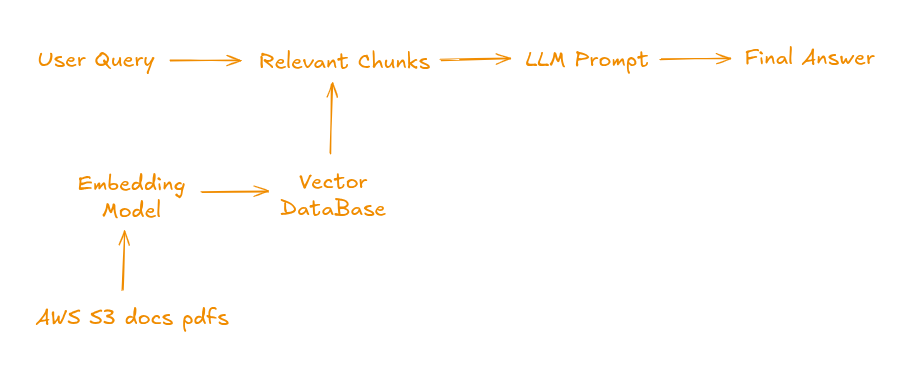

Injecting doc files into kaggle

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/aws-s3/s3-userguide.pdf
/kaggle/input/aws-s3/glacier-dg.pdf
/kaggle/input/aws-s3/s3-outposts.pdf
/kaggle/input/aws-s3/s3-api.pdf


Installing necessary libraries:

In [6]:
%pip install PyPDF2
%pip install langchain
%pip install langchain_community
%pip install langchain_google_genai
%pip install langchain_text_splitters
%pip install sentence-transformers
%pip install langchain-huggingface 

Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 457.9/457.9 kB 7.6 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 1.2.7
    Uninstalling langchain-core-1.2.7:
      Successfully uninstalled langchain-core-1.2.7
  Attempting uninstall: langchain-text-splitters
    Found existing installation: langchain-text-splitters 1.1.0
    Uninstalling langchain-text-splitters-1.1.0:
      Successfully uninstalled langchain-text-splitters-1.1.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-google-genai 4.1.3 requires langchain-core<2.0.0,>=1.2.5, but you have langchain-core 0.3.82 which is incompatible.
langchain-classic 1.0.1 requires langchain-core<2.0.0,>=1.2.5, but you have langchain-core 0.3.82 which is incompatible.
langchain-class

Importing the neccesary packages

In [7]:
from PyPDF2 import PdfReader
from langchain_community.vectorstores import FAISS
from langchain.embeddings import HuggingFaceEmbeddings
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_core.prompts  import PromptTemplate
from langchain_huggingface import ChatHuggingFace, HuggingFaceEndpoint

## Step1 : Load and Preprocess Dataset

In [8]:
pdf_file1 = open('/kaggle/input/aws-s3/glacier-dg.pdf','rb')
pdf_file2 = open('/kaggle/input/aws-s3/s3-api.pdf','rb')
pdf_file3 = open('/kaggle/input/aws-s3/s3-outposts.pdf','rb')
pdf_file4 = open('/kaggle/input/aws-s3/s3-userguide.pdf','rb')

In [9]:
#extracting text from each pdf 
pdf_text1 = ""
pdf_reader = PdfReader(pdf_file1)
for page in pdf_reader.pages:
    pdf_text1 += page.extract_text()

pdf_text2 = ""
pdf_reader = PdfReader(pdf_file2)
for page in pdf_reader.pages:
    pdf_text2 += page.extract_text()

pdf_text3 = ""
pdf_reader = PdfReader(pdf_file3)
for page in pdf_reader.pages:
    pdf_text3 += page.extract_text()

pdf_text4 = ""
pdf_reader = PdfReader(pdf_file4)
for page in pdf_reader.pages:
    pdf_text4 += page.extract_text()

In [10]:
# combining all texts
all_text = pdf_text1 + '\n' + pdf_text2 + '\n' + pdf_text3 + '\n' + pdf_text4
len(all_text)

11685358

In [11]:
#Text Chunking with overlapping
text_splitter = RecursiveCharacterTextSplitter(
        chunk_size = 1000, 
        chunk_overlap = 200, 
        length_function = len,
        separators=['\n', '\n\n', ' ', '']
    )
    
chunks = text_splitter.split_text(text = all_text)

In [12]:
len(chunks)

14671

## Step2: Generate Embeddings

In [13]:
#using huggingface sentence-transformers embeddings model
embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')

/tmp/ipykernel_55/2780943494.py:2: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the `langchain-huggingface package and should be used instead. To use it run `pip install -U `langchain-huggingface` and import as `from `langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings(model_name='sentence-transformers/all-MiniLM-L6-v2')


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

## Step3: Store In VectorDatabase

In [14]:
#usign faiss(in memory database)
vectorstore = FAISS.from_texts(chunks, embedding = embeddings)

## Step4: Retrieval

In [15]:
retriever = vectorstore.as_retriever(search_type="similarity", search_kwargs={"k": 6})

In [16]:
retrieved_docs = retriever.invoke("What kind of data can I store in Amazon S3?")

In [17]:
len(retrieved_docs)

6

In [18]:
print(retrieved_docs[0].page_content)

Amazon S3 provides scalable object storage in the AWS Cloud. It allows you to store and retrieve 
any amount of data from anywhere on the web. Based on its unique architecture, S3 is designed to 
exceed 99.999999999% (11 nines) data durability. Additionally, S3 stores data redundantly across 
a minimum of 3 Availability Zones by default, providing built-in resilience against widespread 
disaster. Customers can store data in a single Availability Zone to minimize storage cost or latency, 
in multiple Availability Zones for resilience against the permanent loss of an entire data center, or 
in multiple AWS Regions to meet geographic resilience requirements.
Amazon S3 data inventory API Version 2006-03-01 2171Amazon Simple Storage Service User Guide
Key Characteristics
Geographic location
Amazon S3 is hosted in multiple locations worldwide. You select locations for your data that 
put them close to your customers.
Buckets


In [19]:
#LLM Prompt injection
prompt_template = """Answer the question as precise as possible using the provided context. If the answer is
                not contained in the context, say "answer not available in context" \n\n
                Context: \n {context}?\n
                Question: \n {question} \n
                Answer:"""

prompt = PromptTemplate.from_template(template=prompt_template)

In [20]:
def format_docs(docs):
    return "\n\n".join(doc.page_content for doc in docs)

In [30]:
#defining kaggle secret for Hugging Face API key
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value = user_secrets.get_secret("HF_TOKEN")


In [31]:
#defined the llm required
hf_llm = HuggingFaceEndpoint(
    repo_id="Qwen/Qwen2.5-7B-Instruct",
    huggingfacehub_api_token=secret_value,
    task="conversational",          
    max_new_tokens=300,
    temperature=0.1,)

## Step5: Generation with LLM

In [33]:
def generate_answer(question):
    chat_llm = ChatHuggingFace(llm=hf_llm)    
    rag_chain = (
        {"context": retriever | format_docs, "question": RunnablePassthrough()}
        | prompt
        | chat_llm
        | StrOutputParser()
    )
    
    return rag_chain.invoke(question)

In [34]:
ans = generate_answer("What kind of data can I store in Amazon S3?")
print(ans)

You can store any amount of data in Amazon S3, ranging from zero to 53.7 TB (48.8 TiB) per object. The content that you store can be any sequence of bytes, and Amazon S3 does not impose restrictions on the type of data. However, the actual maximum object size is determined by multipart upload constraints, which allow for objects up to 53.7 TB.


In [35]:
#this will return no context as this is not related to the text fed
ans = generate_answer("Who is virat kohli")
print(ans)

Answer: Not available in context. The provided context does not contain any information about Virat Kohli.
